In [2]:
import gmt

import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import cm
from matplotlib.colors import rgb2hex

In [3]:
# Load in the data
# Read in only some of the parameters from USGS
col_keep = ['time','latitude','longitude','depth','mag','magType']
df = pd.read_csv('/home/nicole/python/gmt/hawaii_7June.csv', usecols=col_keep)
df.tail(5)

,time,latitude,longitude,depth,mag,magType
1900,2018-06-07T19:15:24.960Z,19.392834,-155.274826,0.56,2.51,ml
1901,2018-06-07T20:12:32.280Z,19.382166,-155.029007,-0.48,2.66,ml
1902,2018-06-07T21:51:18.720Z,19.401833,-155.282333,0.71,2.83,ml
1903,2018-06-07T22:58:20.420Z,19.415667,-155.274500,0.76,2.63,ml
1904,2018-06-07T23:27:48.400Z,19.389166,-155.298828,-0.37,2.50,ml


In [4]:
# Convert date to something more useful

# Create a datetime object column from the 
#string time column using strptime
df['dt_time'] = df['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))

# Add additional columns for day-of-year
df['dofy'] = df['dt_time'].apply(lambda x: x.strftime("%j"))
# Cast the dtype as int (currently an object)
df['dofy'] = df['dofy'].astype(str).astype(int)

# Find the seconds/hours since May 1 UTC 00:00:00
from datetime import timedelta
start_t = datetime(2018,5,1,0,0,0)

# make a timedelta object, find the total seconds, divide to get hours since May 1
df['hrs_may1'] = df['dt_time'].apply(lambda x: (x-start_t).total_seconds()/3600)

In [5]:
# Make the hour interval array

# Plot earthquakes that occur every n hours
interval = 2.
days = (df.dofy.max()-df.dofy.min())+1
hour_bins = np.arange(0., (days*24.), interval)

# Pick from a colormap 
cmap = cm.get_cmap('rainbow', len(hour_bins))

# Convert RGB colors to hex to use in plotting
mycolors = np.empty(0)
for j in range(cmap.N):
    rgb = cmap(j)[:3] # will return rgba; use first 3 to get RGB
    mycolors = np.append(mycolors, [rgb2hex(rgb)])

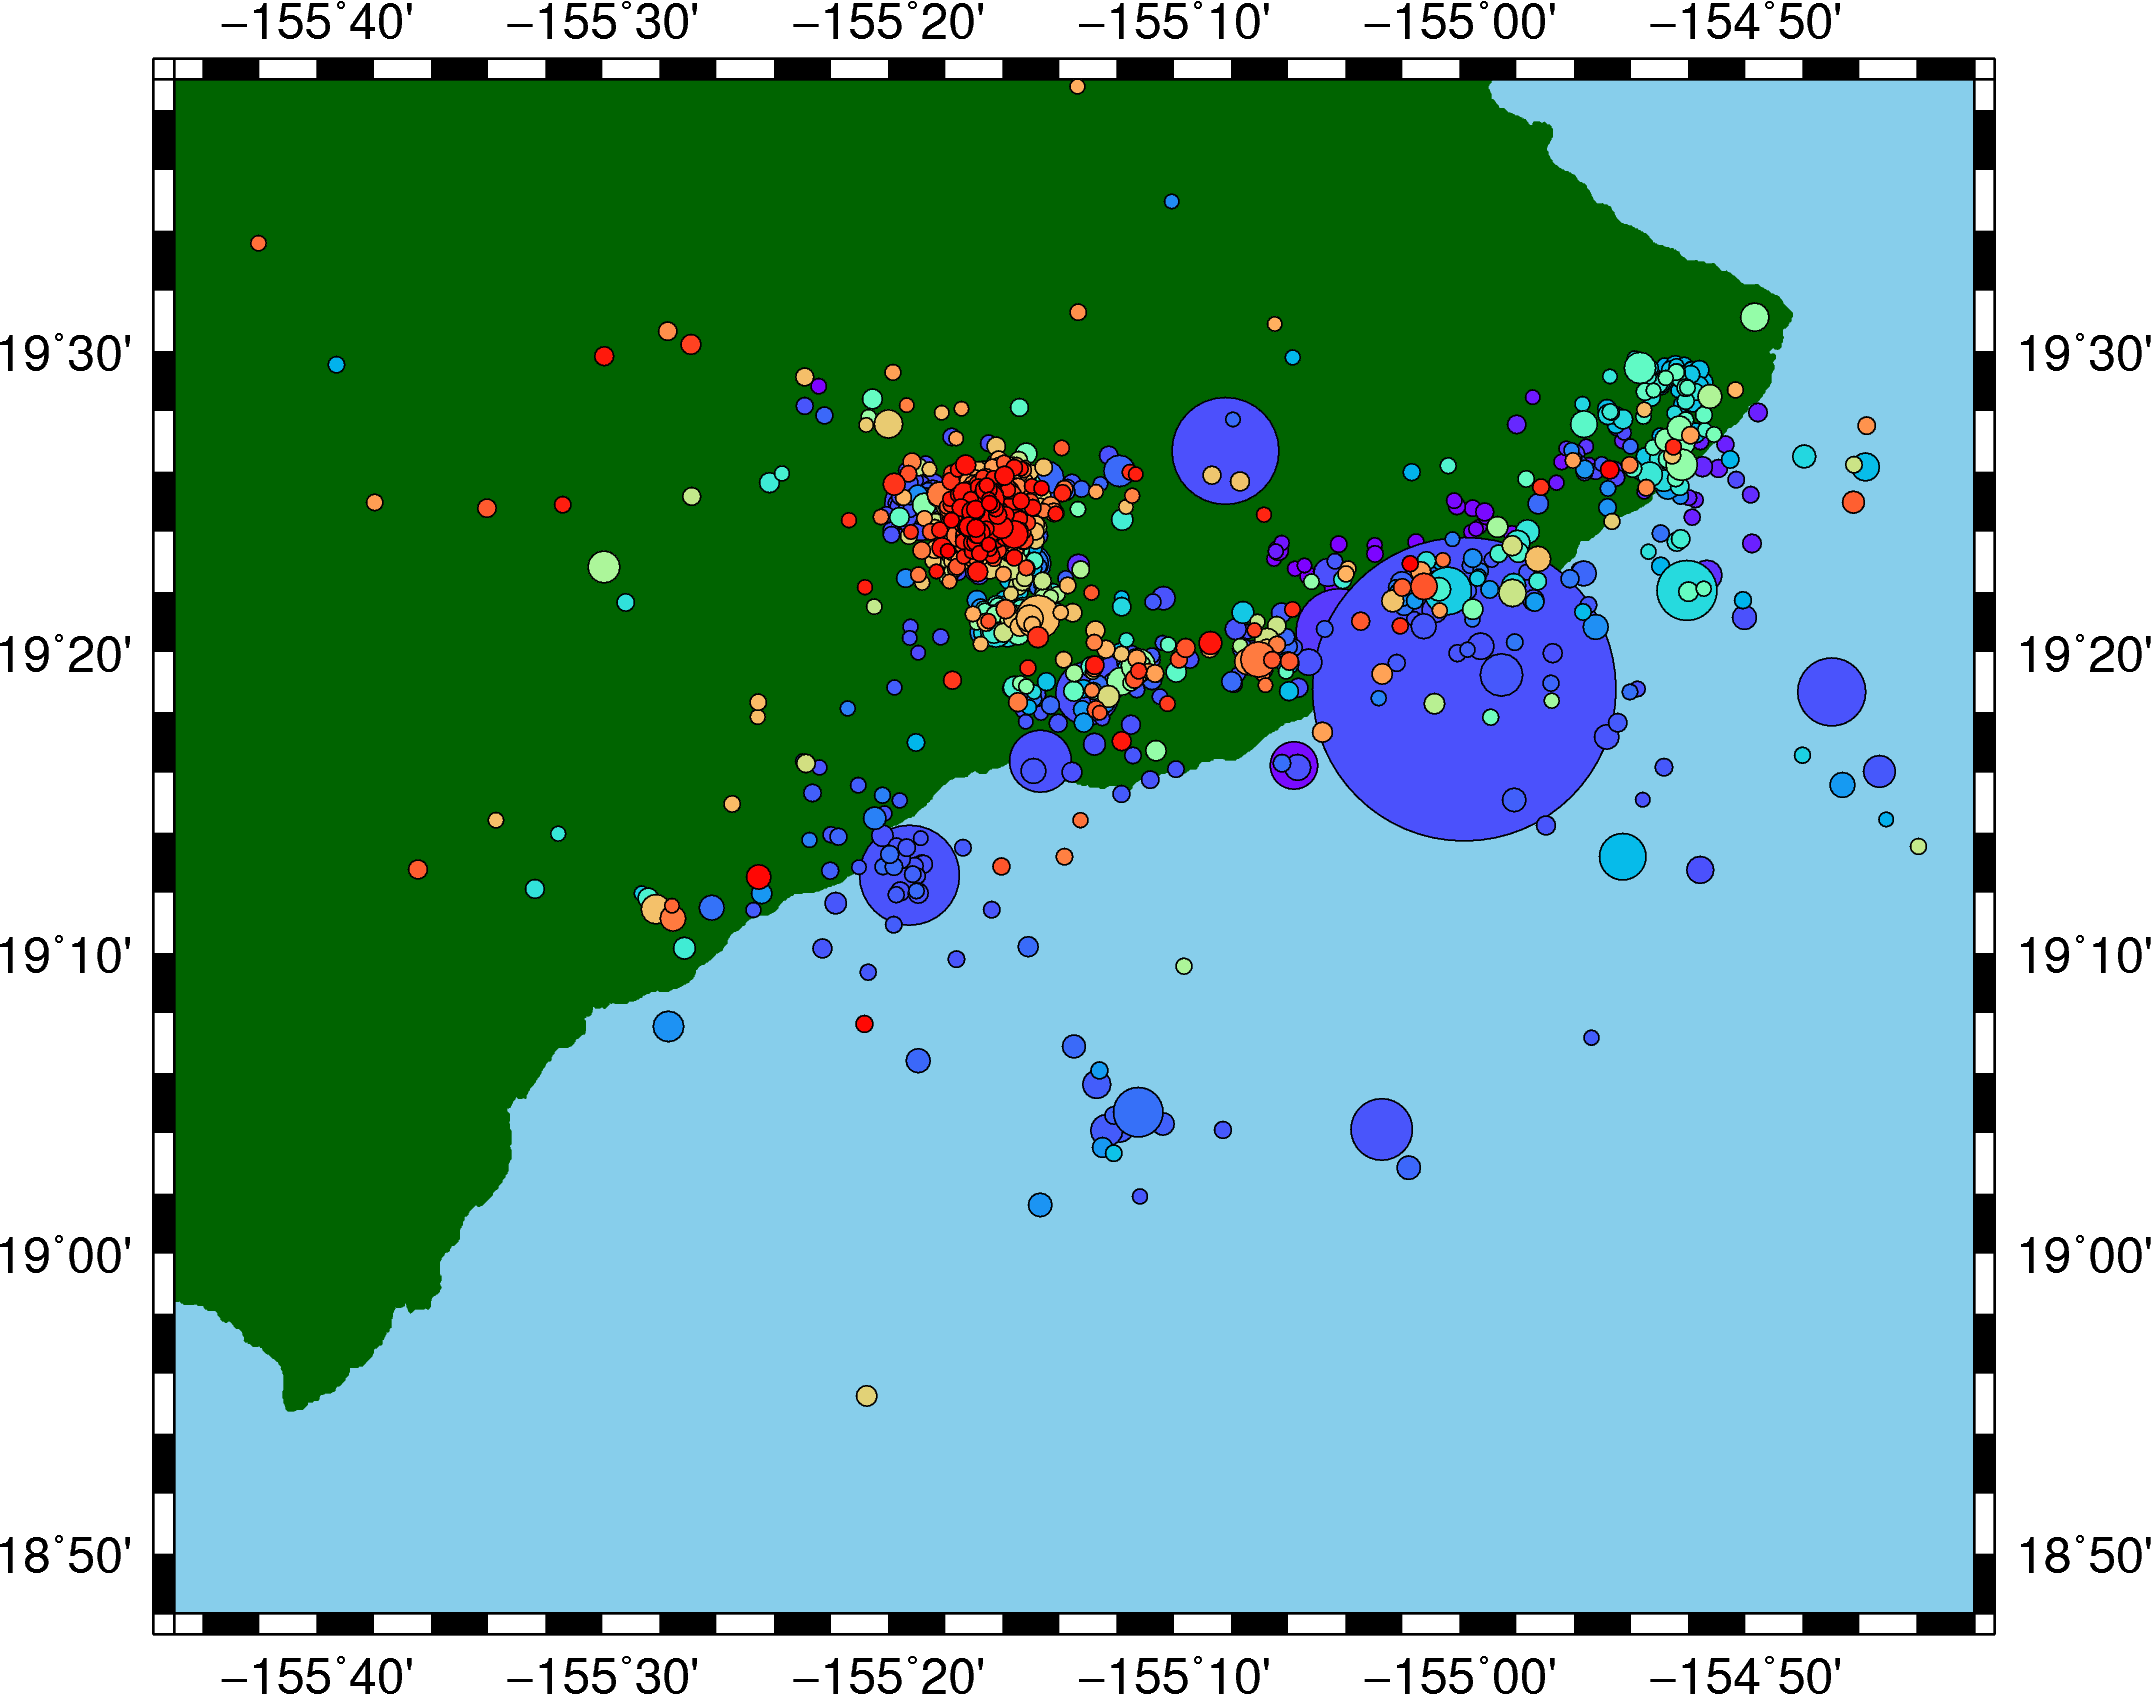

In [7]:
fig = gmt.Figure()
fig.coast(region=[-155.75, -154.7, 18.8, 19.65], projection='M6i', 
          land='darkgreen', water='skyblue', 
          frame=True)

path = '/home/nicole/python/gmt/movies/7June/'

# Plot earthquakes in specified intervals

i=0

for hour in hour_bins:
        
        # find earthquakes in each bin
        df_hour = df[(df['hrs_may1'] >= hour) & (df['hrs_may1'] < hour+2.)]
        
        if len(df_hour.mag) >= 1: # check to make sure there are events in hour bin
            long = df_hour.longitude
            lat = df_hour.latitude
            ev_mag = 0.0215*(2**df_hour.mag) # magnitude sizes
            
            fig.plot(x=long, y=lat, sizes=ev_mag, color=mycolors[i], style='cc', pen='black')            
            file = 'image{0:03d}.png'.format(i)
            fig.savefig(path+file)
            
        else: # save image again with no new events plotted
            file = 'image{0:03d}.png'.format(i)
            fig.savefig(path+file)
           
        i+=1      

fig.show()

In [8]:
# Make an array of hour bins to annotate plots
dt =  datetime(2018, 5, 1, 2, 0, 0)
end = datetime(2018, 6, 3, 2, 0, 0) # do this manually for now
step = timedelta(seconds=2*60*60)

result = []

while dt < end:
    result.append(dt.strftime('%Y-%m-%d %H:%M'))
    dt += step
    
filename = '/home/nicole/python/gmt/movies/7June/dates.txt'

with open(filename, mode="w") as outfile:  
    for s in result:
        outfile.write("%s UTC \n" % s )

In [9]:
%%bash
cd ~/python/gmt/movies/7June/ || exit 1

images=(*.png) # select only the png images, not the dates.txt file

i=0
while read eqdate;
do
    convert -font Ubuntu-Mono -fill black -pointsize 56 -gravity south \
    -draw "text 0,150 '$eqdate'" "${images[i]}" "out_${images[i]}"    
        
    i=$[$i +1]
done <dates.txt

In [10]:
%%bash
cd ~/python/gmt/movies/7June/

ffmpeg -hide_banner -loglevel panic -framerate 10 -i 'out_image%3d.png' -c:v libx264 \
-profile:v high -crf 20 -pix_fmt yuv420p -vf scale=1280:-2 output_7June_10fps.mp4
